In [24]:
import pandas as pd

df = pd.read_csv("dataset_mood_smartphone.csv")
df = df.drop("Unnamed: 0", axis=1)
df['time'] = pd.to_datetime(df["time"])

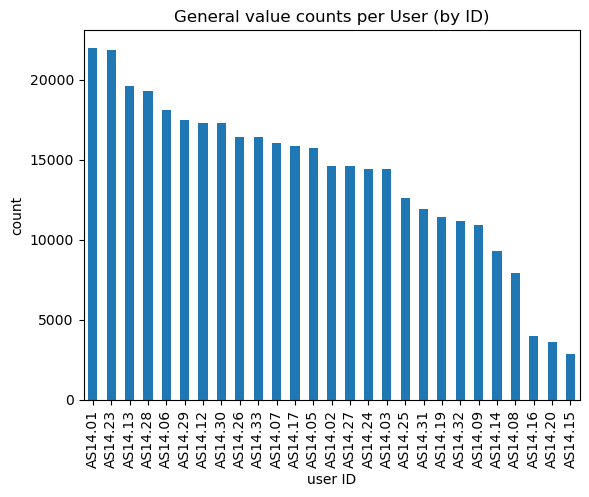

In [3]:
import matplotlib.pyplot as plt
df.id.value_counts().plot(kind="bar")
plt.title("General value counts per User (by ID)")
plt.xlabel("user ID")
plt.ylabel("count")
plt.show()
# we can see that data is not evenly distributed per USER ID


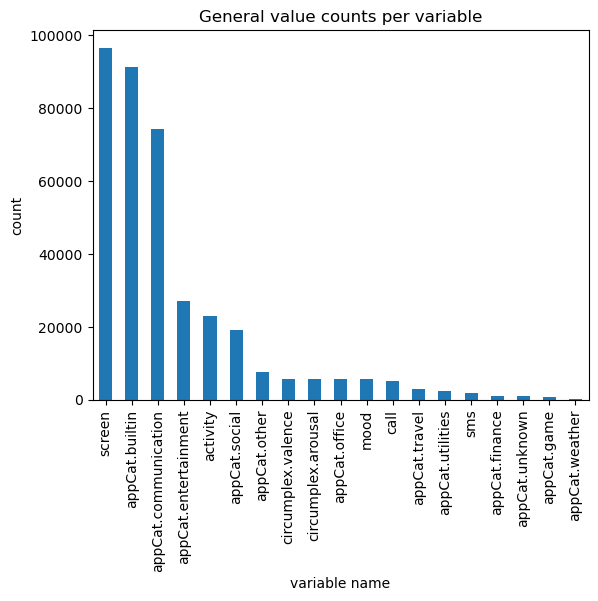

In [5]:
df.variable.value_counts().plot(kind="bar")
plt.title("General value counts per variable")
plt.xlabel("variable name")
plt.ylabel("count")
plt.show()


In [26]:
ids = dict()
for id in df["id"].unique():
    ids[id] = df[df["id"] == id]


vars = dict()
for var in df["variable"].unique():
    vars[var] = df[df["variable"] == var]

ids.keys(), vars.keys()

(dict_keys(['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07', 'AS14.08', 'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15', 'AS14.16', 'AS14.17', 'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24', 'AS14.25', 'AS14.26', 'AS14.27', 'AS14.28', 'AS14.29', 'AS14.30', 'AS14.31', 'AS14.32', 'AS14.33']),
 dict_keys(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']))

#### Plot timeseries function

can be used to plot all of the time series scatter plots at once
- y axis: values of a given variable
- x axis: time

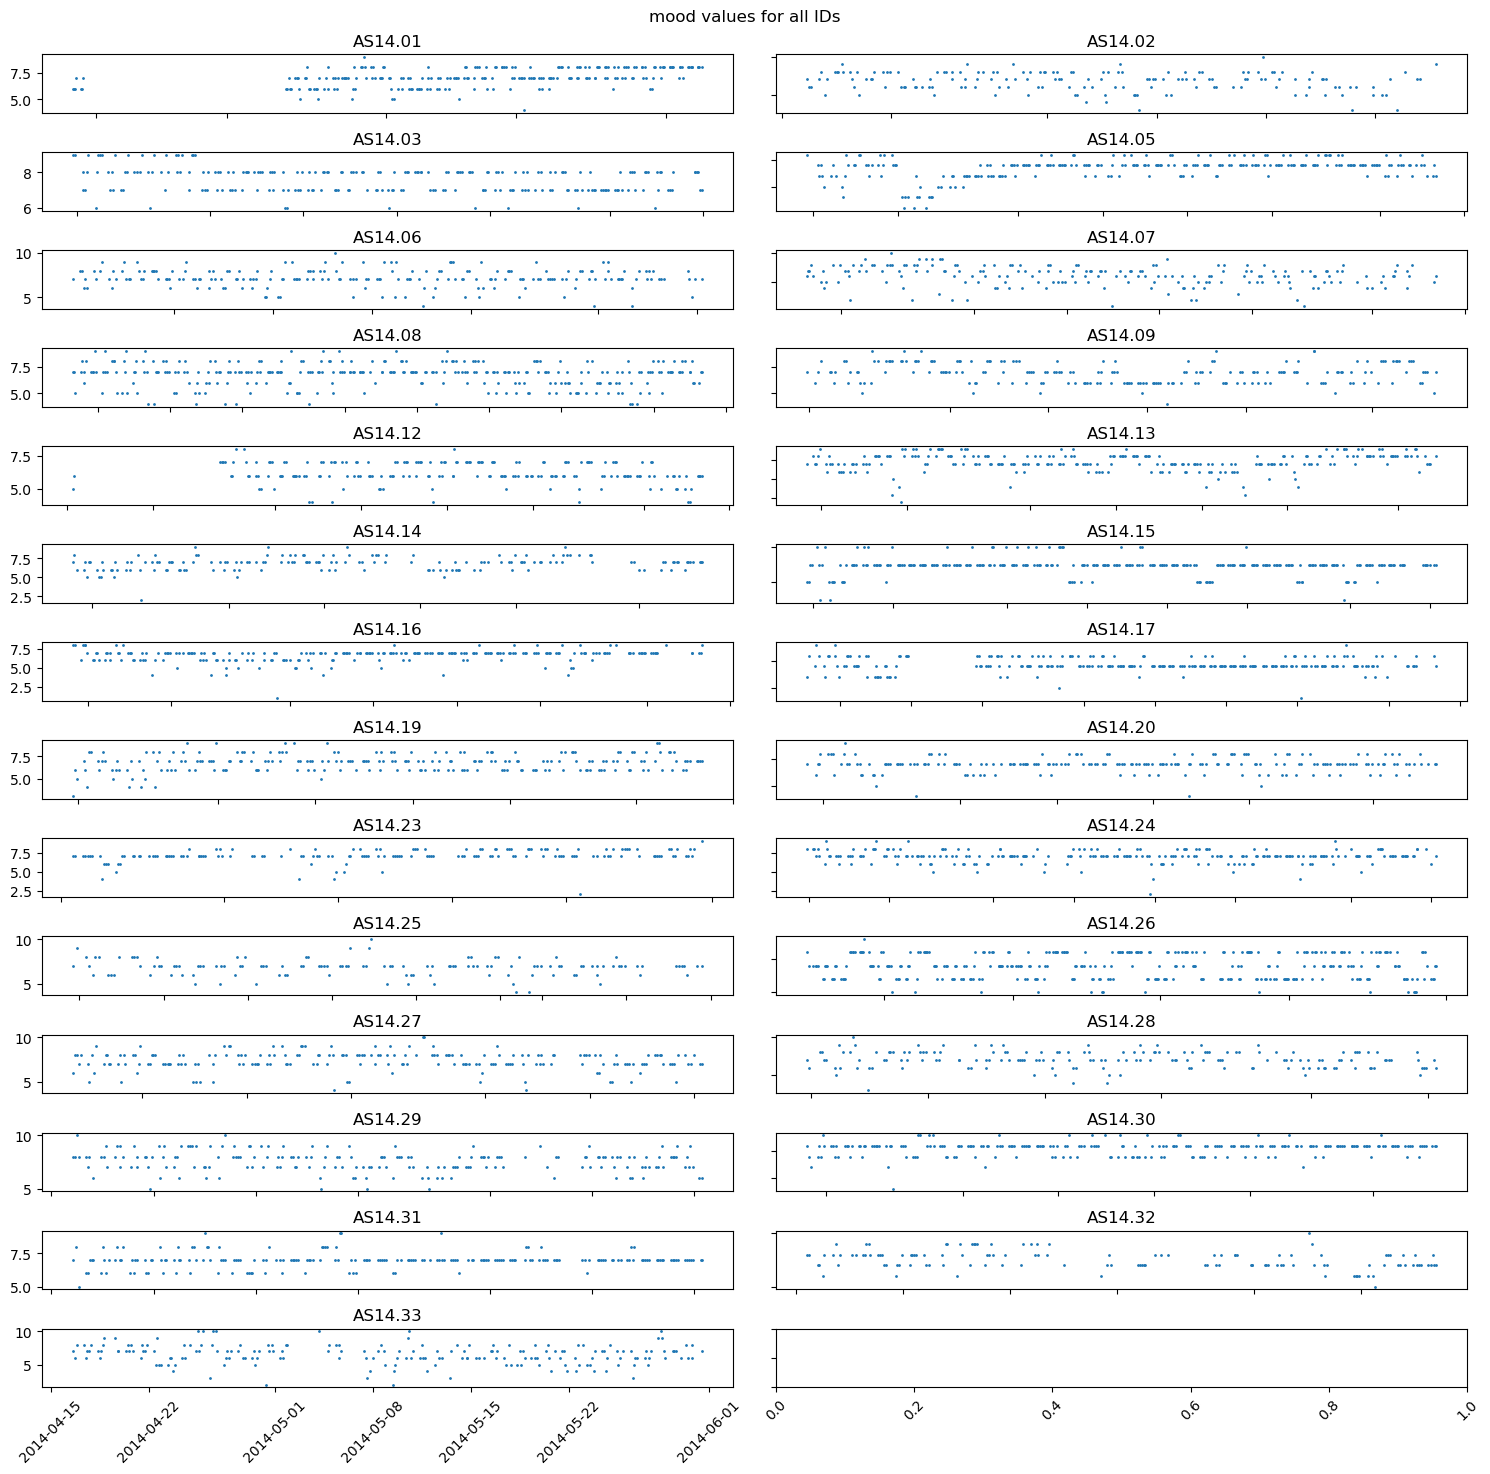

In [81]:
def plot_timeseries(df, variable):
    df = df[df['variable'] == variable]
    id_data = []
    for id in df['id'].unique():
        id_df = df[df['id'] == id]
        id_data.append((id_df['time'], id_df['value'], id))
        
    vertical_axs = 14 # because we have 27 ids in total, 2 per row
    fig, axs = plt.subplots(vertical_axs, 2)
    
    for x in range(vertical_axs):
        id_1 = 2*x
        id_2 = id_1 + 1
        
        # left subplot in a row
        if(id_1 < len(id_data)):
            axs[x, 0].plot_date(id_data[id_1][0], id_data[id_1][1], markersize=1)
            axs[x, 0].set_title(id_data[id_1][2])
        
        # right subplot in a row
        if(id_2 < len(id_data)):
            axs[x, 1].plot_date(id_data[id_2][0], id_data[id_2][1], markersize=1)
            axs[x, 1].set_title(id_data[id_2][2])
    
    for ax in fig.get_axes():
        # only outer labels
        ax.label_outer()
        # rotate labels for timeseries data
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
    
    fig.set_figheight(15)
    fig.set_figwidth(15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.suptitle(f"{variable} values for all IDs")
    

plot_timeseries(df, "mood")

to plot a bigger single plot for a given id

(array([16130., 16144., 16161., 16175., 16191.]),
 [Text(16130.0, 0, '2014-03-01'),
  Text(16144.0, 0, '2014-03-15'),
  Text(16161.0, 0, '2014-04-01'),
  Text(16175.0, 0, '2014-04-15'),
  Text(16191.0, 0, '2014-05-01')])

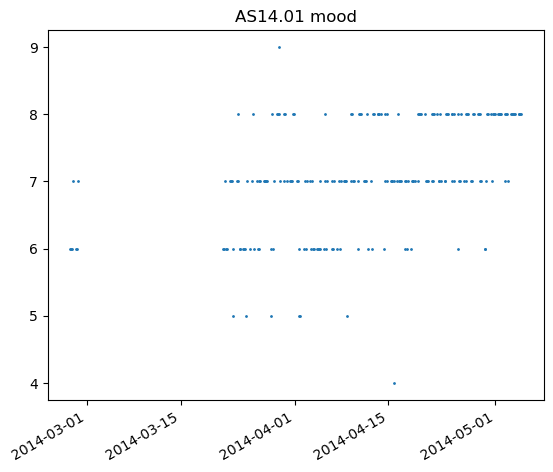

In [86]:
variable = 'mood'
id = 'AS14.01'
df_1 = df[df['variable'] == variable]
df_1 = df_1[df_1['id'] == id]
plt.plot_date(df_1['time'], df_1['value'], markersize=1) 
plt.title(f"{id} {variable}")
 
plt.xticks(rotation=30, ha='right')

In [87]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df[df['variable'] == variable], title="Report")
profile

Render HTML: 100%|████████████████████████████████| 1/1 [00:00<00:00, 10.76it/s]
